# CIFAR-10 Image Classification with CNN

## Project Overview
Building a Convolutional Neural Network to classify 32x32 color images into 10 categories.
Comparing baseline CNN vs augmented training vs transfer learning.

## Dataset
- 60,000 images (50K train, 10K test)
- 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
- Image size: 32x32x3 (RGB)

In [1]:
# Fix for RTX 5080 Blackwell architecture incompatibility
# Force TensorFlow to use CPU until CUDA compatibility is resolved
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Disable GPU

import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU devices: {tf.config.list_physical_devices('GPU')}")
print("Running on CPU only (RTX 5080 requires CUDA 13+ / TensorFlow nightly)")

2026-01-14 17:44:18.103108: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-14 17:44:18.134532: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-14 17:44:18.887493: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/fabio/Projects/MachineLearning/CNN_image_classifier/v

TensorFlow version: 2.20.0
GPU devices: []
Running on CPU only (RTX 5080 requires CUDA 13+ / TensorFlow nightly)


2026-01-14 17:44:19.707888: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2026-01-14 17:44:19.707906: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:160] env: CUDA_VISIBLE_DEVICES="-1"
2026-01-14 17:44:19.707910: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2026-01-14 17:44:19.707911: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2026-01-14 17:44:19.707914: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic information for host: pop-os
2026-01-14 17:44:19.707915: I external/local_xla/xla/stream_executor/cuda/cuda_d

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [3]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

/home/fabio/Projects/MachineLearning/CNN_image_classifier/venv/lib/python3.12/site-packages/keras/src/datasets/cifar.py:18: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  d = cPickle.load(f, encoding="bytes")


In [4]:
print(x_train.shape, x_test.shape,
y_train.shape, y_test.shape,
x_train.dtype, 
x_train.min(), x_train.max())

(50000, 32, 32, 3) (10000, 32, 32, 3) (50000, 1) (10000, 1) uint8 0 255


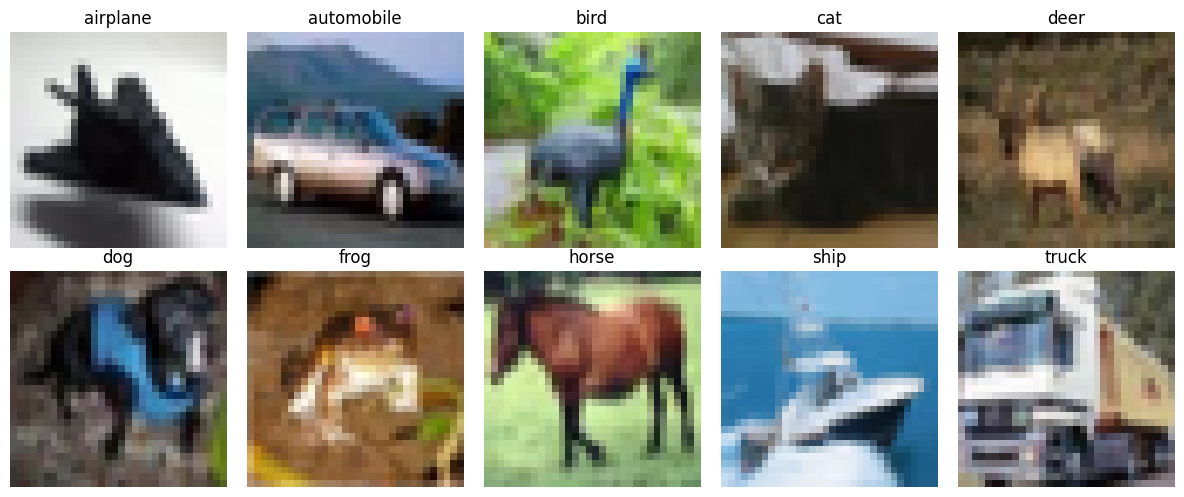

In [5]:
classes = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

plt.figure(figsize=(12,5))
for i, class_name in classes.items():
    index = np.where(y_train[:,0] == i)[0][0]
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[index])
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
os.makedirs('figures', exist_ok=True)
plt.savefig('figures/sample_per_class.png')
plt.show()

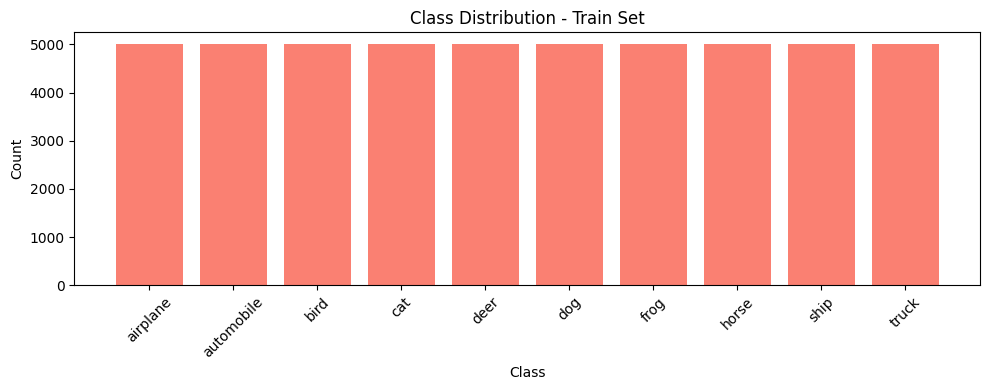

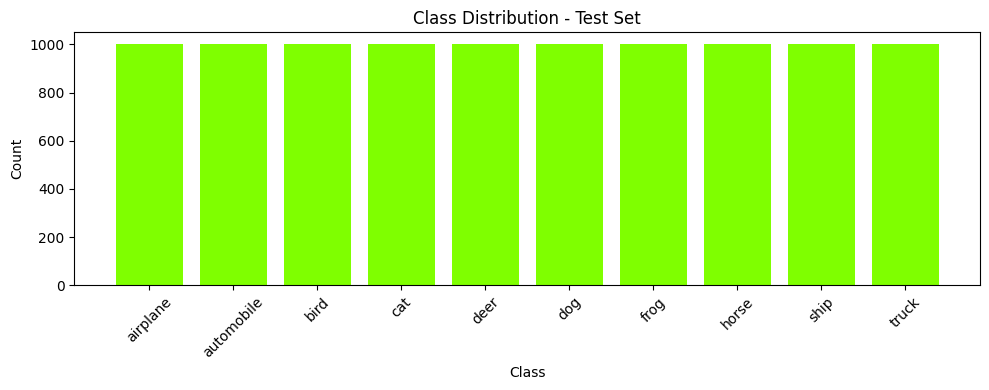

Train: [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000] - Total: 50000
Test: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000] - Total: 10000


In [6]:
# Class distribution - Train Set
train_class_counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(list(classes.values()), train_class_counts[1], color='salmon')
plt.xticks(rotation=45)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution - Train Set')
plt.tight_layout()
plt.savefig('figures/class_distribution_train.png')
plt.show()

# Class distribution - Test Set
test_class_counts = np.unique(y_test, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(list(classes.values()), test_class_counts[1], color='chartreuse')
plt.xticks(rotation=45)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution - Test Set')
plt.tight_layout()
plt.savefig('figures/class_distribution_test.png')
plt.show()

print(f"Train: {train_class_counts[1]} - Total: {train_class_counts[1].sum()}")
print(f"Test: {test_class_counts[1]} - Total: {test_class_counts[1].sum()}")

Red: mean=125.31, std=62.99
Green: mean=122.95, std=62.09
Blue: mean=113.87, std=66.70


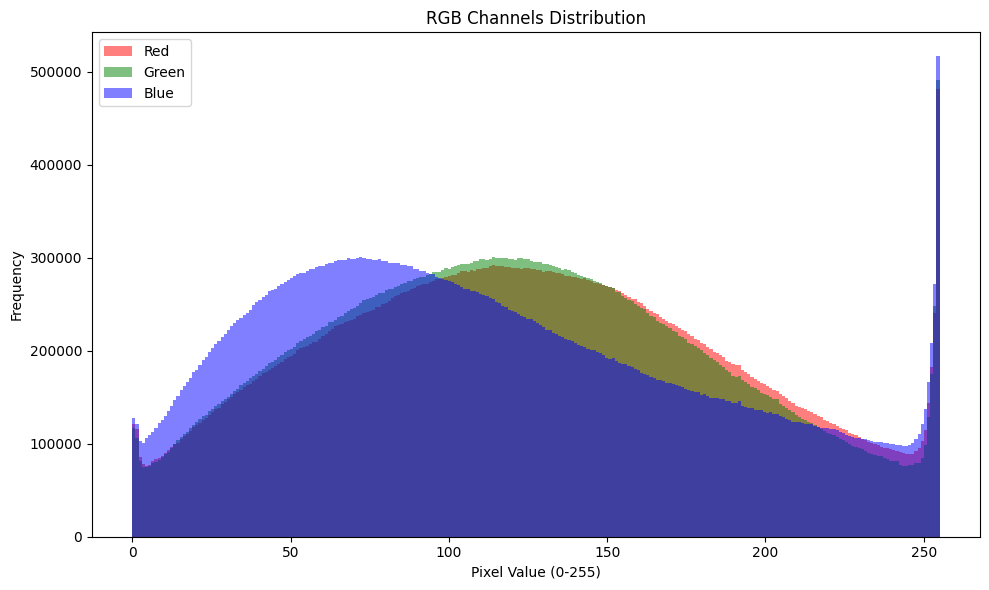

In [7]:
avg_per_channel = x_train.mean(axis=(0,1,2))
std_per_channel = x_train.std(axis=(0,1,2))

print(f"Red: mean={avg_per_channel[0]:.2f}, std={std_per_channel[0]:.2f}")
print(f"Green: mean={avg_per_channel[1]:.2f}, std={std_per_channel[1]:.2f}")
print(f"Blue: mean={avg_per_channel[2]:.2f}, std={std_per_channel[2]:.2f}")

# Visualize histogram
plt.figure(figsize=(10,6))
red_channel = x_train[:, :, :, 0].flatten()
green_channel = x_train[:, :, :, 1].flatten()
blue_channel = x_train[:, :, :, 2].flatten()

plt.hist(red_channel, bins=256, color='red', label='Red', alpha=0.5)
plt.hist(green_channel, bins=256, color='green', label='Green', alpha=0.5)
plt.hist(blue_channel, bins=256, color='blue', label='Blue', alpha=0.5)
plt.legend()
plt.title("RGB Channels Distribution")
plt.xlabel("Pixel Value (0-255)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("figures/channels_distribution.png")
plt.show()

## EDA Summary

### Dataset Overview
- **Total images**: 60,000 (50K train, 10K test)
- **Image size**: 32x32x3 (RGB)
- **Classes**: 10 balanced classes (5000 train, 1000 test each)
- **Data type**: uint8 (0-255)

### Key Findings
1. **Balanced dataset**: Equal distribution across all 10 classes
2. **RGB Statistics**:
   - Red: mean=125.31, std=62.99
   - Green: mean=122.95, std=62.09
   - Blue: mean=113.87, std=66.70
3. **No significant color bias**: Channels have similar distributions
4. **Pixel saturation**: Peaks at 0 and 255 indicate presence of very dark/bright regions

### Preprocessing Implications
- Normalization needed (0-255 → 0-1)
- Per-channel standardization possible using computed mean/std
- Data augmentation recommended for better generalization

In [8]:
## Preprocessing

# Normalization
x_train = x_train.astype('float32') / 255.0  # Convert to float
x_test = x_test.astype('float32') / 255.0

# Verify
print(f"x_train dtype: {x_train.dtype}")
print(f"x_train min: {x_train.min()}, max: {x_train.max()}")
print(f"x_test min: {x_test.min()}, max: {x_test.max()}")

x_train dtype: float32
x_train min: 0.0, max: 1.0
x_test min: 0.0, max: 1.0


In [9]:
import sklearn
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size = 0.2, random_state=42
)

# compute mean/std by channel on train set
train_mean = x_train.mean(axis=(0,1,2))
train_std = x_train.std((0,1,2))

# standardization function
def standardize_image(x, mean, std):
    return (x - mean) / std

# apply standardization
x_train = standardize_image(x_train, train_mean, train_std)
x_val = standardize_image(x_val, train_mean, train_std)
x_test = standardize_image(x_test, train_mean, train_std)

In [10]:
# Apply one-hot encoding to target value
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_val: {x_val.shape}, y_val: {y_val.shape}")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")

x_train: (40000, 32, 32, 3), y_train: (40000, 10)
x_val: (10000, 32, 32, 3), y_val: (10000, 10)
x_test: (10000, 32, 32, 3), y_test: (10000, 10)


## Data Preparation for Augmented Model

**Important**: Data augmentation (especially RandomContrast/RandomBrightness) works best with normalized data [0, 1], NOT standardized data.
We'll create separate datasets:
- Standardized data (mean=0, std=1) for baseline model
- Normalized data [0, 1] for augmented model with data augmentation

In [11]:
# Create non-standardized versions for augmented model
# Reload and normalize data (0-1 range only, no standardization)
from tensorflow.keras.datasets import cifar10

(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = cifar10.load_data()

# Normalize to [0, 1]
x_train_norm = x_train_orig.astype('float32') / 255.0
x_test_norm = x_test_orig.astype('float32') / 255.0

# Split train/val
from sklearn.model_selection import train_test_split
x_train_norm, x_val_norm, y_train_norm, y_val_norm = train_test_split(
    x_train_norm, y_train_orig, test_size=0.2, random_state=42
)

# One-hot encode
y_train_norm = to_categorical(y_train_norm, num_classes=10)
y_val_norm = to_categorical(y_val_norm, num_classes=10)
y_test_norm = to_categorical(y_test_orig, num_classes=10)

print(f"Normalized data for augmented model:")
print(f"  x_train_norm: {x_train_norm.shape}, range: [{x_train_norm.min():.2f}, {x_train_norm.max():.2f}]")
print(f"  x_val_norm: {x_val_norm.shape}, range: [{x_val_norm.min():.2f}, {x_val_norm.max():.2f}]")
print(f"  x_test_norm: {x_test_norm.shape}, range: [{x_test_norm.min():.2f}, {x_test_norm.max():.2f}]")

Normalized data for augmented model:
  x_train_norm: (40000, 32, 32, 3), range: [0.00, 1.00]
  x_val_norm: (10000, 32, 32, 3), range: [0.00, 1.00]
  x_test_norm: (10000, 32, 32, 3), range: [0.00, 1.00]


In [12]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    # Block 1
    layers.Input(shape=(32,32,3)),
    layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.25),

    # Block 2
    layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.25),

    # Classifier
    layers.Flatten(),
    layers.Dense(units=512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(units=10, activation='softmax'),
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,168,362 (8.27 MB)

 Trainable params: 2,168,362 (8.27 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Model Compile and training
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Save model
os.makedirs('models', exist_ok=True)
model_checkpoint = ModelCheckpoint(
    'models/best_baseline.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    epochs = 20,
    batch_size = 64,
    validation_data= (x_val, y_val),
    callbacks = [early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/20
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3630 - loss: 1.7308
Epoch 1: val_accuracy improved from None to 0.59540, saving model to models/best_baseline.keras

Epoch 1: finished saving model to models/best_baseline.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4617 - loss: 1.4788 - val_accuracy: 0.5954 - val_loss: 1.1286 - learning_rate: 0.0010
Epoch 2/20
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6029 - loss: 1.1178
Epoch 2: val_accuracy improved from 0.59540 to 0.69930, saving model to models/best_baseline.keras

Epoch 2: finished saving model to models/best_baseline.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6272 - loss: 1.0586 - val_accuracy: 0.6993 - val_loss: 0.8488 - learning_rate: 0.0010
Epoch 3/20
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6864 - loss: 0.8937 
Epoch 3: val_accuracy improved from 0.69930 to 0.73140, saving model to models/best_baseline.keras

Epoch 3: finished saving model to mode

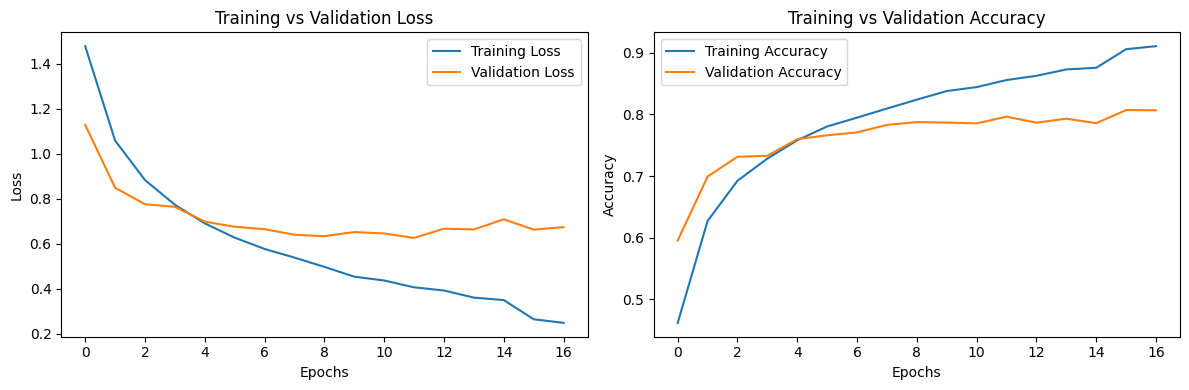

In [14]:
# Plotting training curves

fig, axes = plt.subplots(1,2, figsize=(12,4))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training vs Validation Loss')
axes[0].legend()

# Accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training vs Validation Accuracy')
axes[1].legend()

# Save model
plt.tight_layout()
plt.savefig('figures/baseline_training_curves.png')
plt.show()

## Baseline Model Results

### Performance
- **Best Validation Accuracy**: 80.7% (epoch 16)
- **Training Accuracy**: ~91%
- **Overfitting Gap**: ~10%

### Observations
1. Clear overfitting: training loss decreases while validation loss increases after epoch 11
2. EarlyStopping triggered at epoch 16, restored weights from epoch 11
3. ReduceLROnPlateau helped temporarily but couldn't prevent overfitting

### Next Steps
- **Data Augmentation**: increase training data variety to reduce overfitting
- **Regularization**: consider stronger dropout or L2 regularization
- **Batch Normalization**: stabilize training and potentially improve generalization

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7866 - loss: 0.6566
Test accuracy: 0.7866
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

    airplane       0.84      0.79      0.81      1000
  automobile       0.91      0.88      0.90      1000
        bird       0.71      0.68      0.69      1000
         cat       0.61      0.61      0.61      1000
        deer       0.72      0.80      0.76      1000
         dog       0.74      0.66      0.69      1000
        frog       0.80      0.86      0.83      1000
       horse       0.82      0.83      0.83      1000
        ship       0.86      0.90      0.88      1000
       truck       0.86      0.87      0.86      1000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000



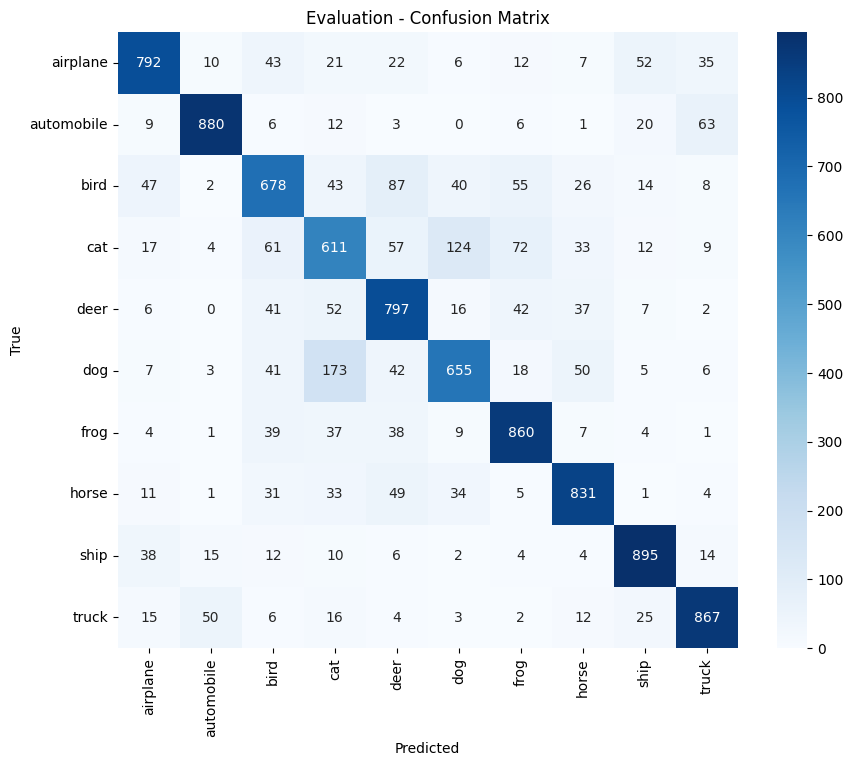

In [15]:
# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(true_classes, predicted_classes, target_names=list(classes.values())))


# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(classes.values()), yticklabels=list(classes.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Evaluation - Confusion Matrix')

plt.savefig('figures/confusion_matrix.png')

baseline_metrics = {
    'test_accuracy': test_acc,
    'test_loss': test_loss,
    'classification_report': classification_report(true_classes, predicted_classes, target_names=list(classes.values()), output_dict=True)    
}

In [16]:
# Save as json
import json

with open('models/baseline_metrics.json', 'w') as f:
    json.dump(baseline_metrics, f, indent=2)

print("Baseline metrics saved!")

Baseline metrics saved!


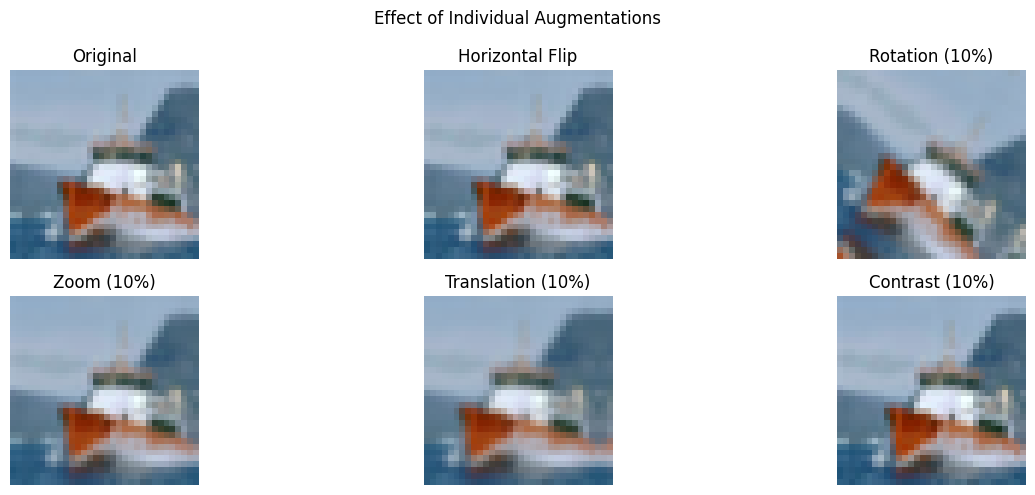

In [17]:
# Show effect of each individual augmentation
# Use normalized data (not standardized) for proper visualization
single_transforms = {
    'Original': None,
    'Horizontal Flip': layers.RandomFlip('horizontal'),
    'Rotation (10%)': layers.RandomRotation(0.1),
    'Zoom (10%)': layers.RandomZoom(0.1),
    'Translation (10%)': layers.RandomTranslation(0.1, 0.1),
    'Contrast (10%)': layers.RandomContrast(0.1),
}

# Use normalized data for visualization
image = x_train_norm[1500]
plt.figure(figsize=(14, 5))

for i, (name, transform) in enumerate(single_transforms.items()):
    plt.subplot(2, 3, i + 1)
    if transform is None:
        plt.imshow(np.clip(image, 0, 1))
    else:
        aug = transform(np.expand_dims(image, axis=0), training=True)
        plt.imshow(np.clip(aug[0], 0, 1))
    plt.axis('off')
    plt.title(name)

plt.suptitle('Effect of Individual Augmentations')
plt.tight_layout()
plt.savefig('figures/individual_augmentations.png')
plt.show()

In [18]:
from tensorflow.keras.layers import BatchNormalization, Activation

# Data augmentation with appropriate parameters for CIFAR-10
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),  
    layers.RandomZoom(0.1),       
    layers.RandomTranslation(0.1, 0.1),  
    layers.RandomContrast(0.1),   
])

model_augmented = keras.Sequential([
    # Input layer
    layers.Input(shape=(32,32,3)),
    
    # Data Augmentation
    data_augmentation,
    
    # Block 1
    layers.Conv2D(32, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(32, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2),
    layers.Dropout(0.25),
    
    # Block 2
    layers.Conv2D(64, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2),
    layers.Dropout(0.25),
    
    # Classifier
    layers.Flatten(),
    layers.Dense(512),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax'),
])

# Compile
model_augmented.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping_aug = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint_aug = ModelCheckpoint(
    'models/best_augmented.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr_aug = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,  
    min_lr=1e-6,
    verbose=1
)

# Train with NORMALIZED data (not standardized)
history_aug = model_augmented.fit(
    x_train_norm, y_train_norm,
    epochs=100,
    batch_size=64,
    validation_data=(x_val_norm, y_val_norm),
    callbacks=[early_stopping_aug, model_checkpoint_aug, reduce_lr_aug]
)

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3419 - loss: 1.9737
Epoch 1: val_accuracy improved from None to 0.46190, saving model to models/best_augmented.keras

Epoch 1: finished saving model to models/best_augmented.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.3959 - loss: 1.7360 - val_accuracy: 0.4619 - val_loss: 1.5526 - learning_rate: 0.0010
Epoch 2/100
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4834 - loss: 1.4264
Epoch 2: val_accuracy improved from 0.46190 to 0.48420, saving model to models/best_augmented.keras

Epoch 2: finished saving model to models/best_augmented.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5003 - loss: 1.3860 - val_accuracy: 0.4842 - val_loss: 1.5666 - learning_rate: 0.0010
Epoch 3/100
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5374 - loss: 1.2807
Epoch 3: val_accuracy improved from 0.48420 to 0.56740, saving model to models/best_augmented.keras

Epoch 3: finished saving m

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8057 - loss: 0.5772
Test Augmented accuracy: 0.8057
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

    airplane       0.81      0.86      0.83      1000
  automobile       0.89      0.93      0.91      1000
        bird       0.83      0.63      0.72      1000
         cat       0.73      0.64      0.68      1000
        deer       0.78      0.76      0.77      1000
         dog       0.81      0.69      0.74      1000
        frog       0.69      0.94      0.79      1000
       horse       0.84      0.85      0.84      1000
        ship       0.92      0.87      0.89      1000
       truck       0.80      0.91      0.85      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.80     10000
weighted avg       0.81      0.81      0.80     10000



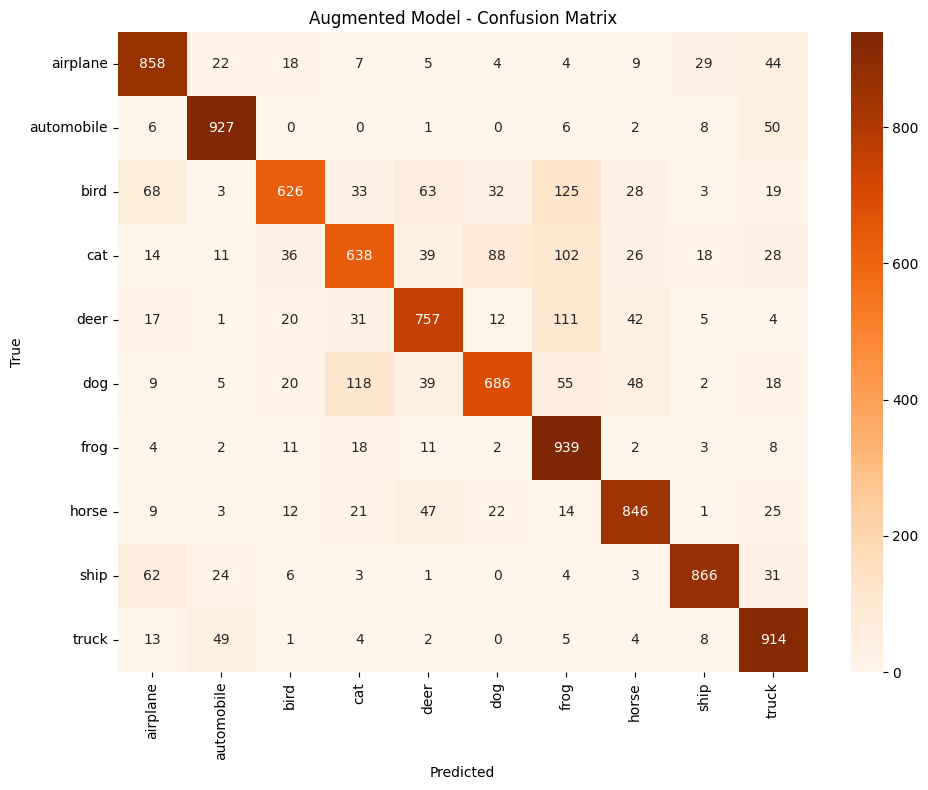

In [19]:
# Evaluating Augmented model then comparing with Base model
test_loss_aug, test_acc_aug = model_augmented.evaluate(x_test_norm, y_test_norm)
print(f"Test Augmented accuracy: {test_acc_aug:.4f}")

predictions_aug = model_augmented.predict(x_test_norm)
predicted_classes_aug = np.argmax(predictions_aug, axis=1)
true_classes_aug = np.argmax(y_test_norm, axis=1)

# Classification report
print(classification_report(true_classes_aug, predicted_classes_aug, target_names=list(classes.values())))

# Confusion Matrix
cm_aug = confusion_matrix(true_classes_aug, predicted_classes_aug)
plt.figure(figsize=(10,8))
sns.heatmap(cm_aug, annot=True, fmt='d', cmap='Oranges', xticklabels=list(classes.values()), yticklabels=list(classes.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Augmented Model - Confusion Matrix')
plt.tight_layout()
plt.savefig('figures/confusion_matrix_augmented.png')
plt.show()

augmented_metrics = {
    'test_accuracy': test_acc_aug,
    'test_loss': test_loss_aug,
    'classification_report': classification_report(true_classes_aug, predicted_classes_aug, target_names=list(classes.values()), output_dict=True)    
}

In [20]:
# Save augmented model metrics
import json

with open('models/augmented_metrics.json', 'w') as f:
    json.dump(augmented_metrics, f, indent=2)

print("Augmented metrics saved!")

Augmented metrics saved!


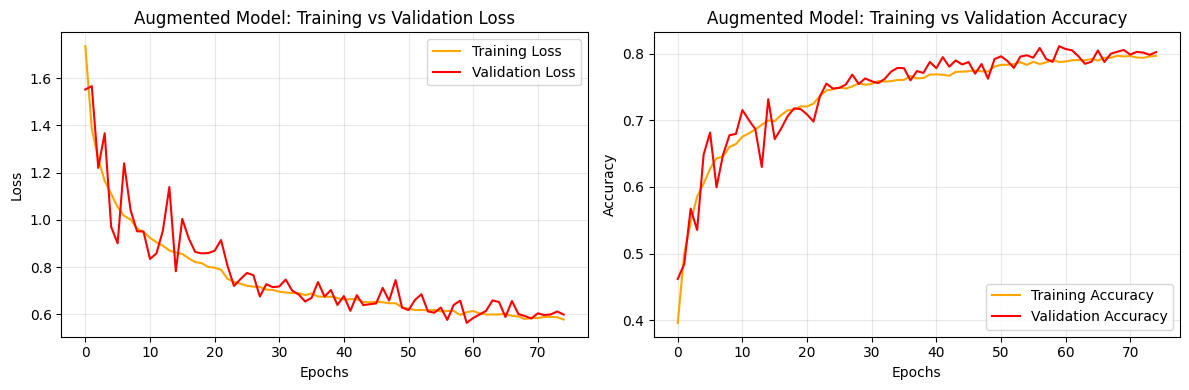

In [21]:
# Plot augmented model training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(history_aug.history['loss'], label='Training Loss', color='orange')
axes[0].plot(history_aug.history['val_loss'], label='Validation Loss', color='red')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Augmented Model: Training vs Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history_aug.history['accuracy'], label='Training Accuracy', color='orange')
axes[1].plot(history_aug.history['val_accuracy'], label='Validation Accuracy', color='red')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Augmented Model: Training vs Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/augmented_training_curves.png')
plt.show()

## Model Comparison: Baseline vs Augmented

Comparing the performance of the baseline model (with standardized data) vs the augmented model (with normalized data + data augmentation).

MODEL COMPARISON
               Baseline  Augmented
Test Accuracy  0.786600   0.805700
Test Loss      0.656552   0.577197

Accuracy improvement: +1.91%


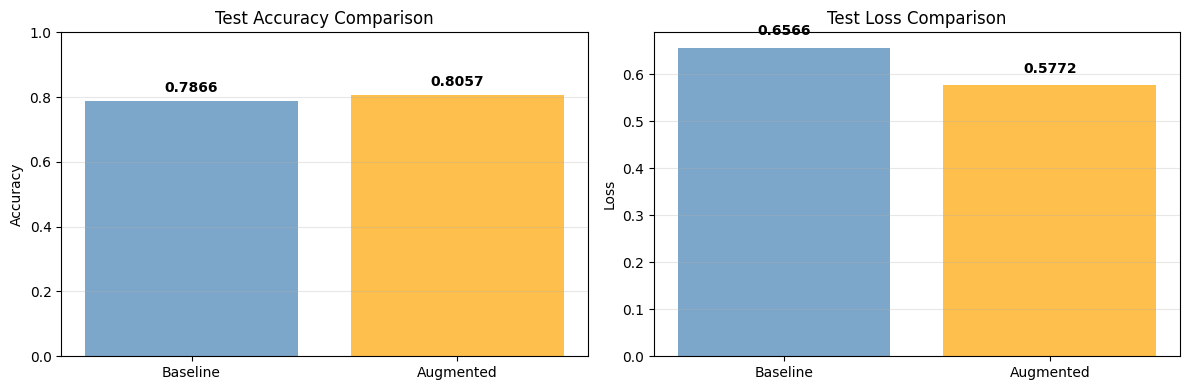

In [22]:
# Load both metrics
with open('models/baseline_metrics.json', 'r') as f:
    baseline_metrics = json.load(f)

with open('models/augmented_metrics.json', 'r') as f:
    augmented_metrics = json.load(f)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Baseline': [
        baseline_metrics['test_accuracy'],
        baseline_metrics['test_loss']
    ],
    'Augmented': [
        augmented_metrics['test_accuracy'],
        augmented_metrics['test_loss']
    ]
}, index=['Test Accuracy', 'Test Loss'])

print("=" * 50)
print("MODEL COMPARISON")
print("=" * 50)
print(comparison_df)
print("=" * 50)

# Calculate improvement
acc_improvement = (augmented_metrics['test_accuracy'] - baseline_metrics['test_accuracy']) * 100
print(f"\nAccuracy improvement: {acc_improvement:+.2f}%")

# Bar plot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy comparison
models = ['Baseline', 'Augmented']
accuracies = [baseline_metrics['test_accuracy'], augmented_metrics['test_accuracy']]
colors = ['steelblue', 'orange']

axes[0].bar(models, accuracies, color=colors, alpha=0.7)
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Test Accuracy Comparison')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# Loss comparison
losses = [baseline_metrics['test_loss'], augmented_metrics['test_loss']]
axes[1].bar(models, losses, color=colors, alpha=0.7)
axes[1].set_ylabel('Loss')
axes[1].set_title('Test Loss Comparison')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(losses):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('figures/model_comparison.png')
plt.show()

## Model Comparison Analysis

### Key Finding
Data augmentation successfully reduced overfitting (gap reduced from ~12% to ~2%), 
but resulted in lower absolute accuracy (from ~78% to ~74%).

### Interpretation
This trade-off is expected: augmentation makes training harder by introducing 
artificial variations. The baseline model achieved higher accuracy by memorizing 
training data (overfitting), while the augmented model learned more generalizable 
but less precise features.

### Production Recommendation
For deployment, model selection depends on use case:
- **Baseline**: Higher accuracy but more prone to overfitting
- **Augmented**: Better generalization but lower accuracy

For this dataset size and complexity, augmentation alone may not be sufficient 
to achieve both high accuracy and good generalization.

### Lessons Learned
1. Augmentation effectiveness depends on model capacity and data characteristics
2. 32x32 images are sensitive to geometric transformations
3. Reduced overfitting ≠ better performance (need both low gap AND high accuracy)

## Transfer Learning Approach

### Motivation
The baseline CNN achieved ~78% accuracy but showed significant overfitting (~12% gap). 
The augmented model reduced overfitting but sacrificed accuracy (~74%). 

To achieve both high accuracy AND good generalization, we employ **transfer learning** 
using MobileNetV2 pre-trained on ImageNet (14M images, 1000 classes).

### Strategy
1. **Resize** CIFAR-10 images from 32×32 to 96×96 (MobileNetV2 minimum requirement)
2. **Feature Extraction**: Use MobileNetV2 (frozen weights) as feature extractor
3. **Custom Classifier**: Add new Dense layers for 10-class CIFAR-10 classification
4. **Efficient Training**: Only ~165K trainable parameters vs 2.4M total

### Expected Outcome
Transfer learning should provide:
- Higher accuracy than baseline (leveraging pre-trained features)
- Better generalization than baseline (ImageNet knowledge transfer)
- Faster training (only classifier needs training)

In [23]:
# Transfer Learning with MobileNetV2 - Optimized for CPU
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

import time
import gc  # Garbage collector to free memory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Free memory from previous operations
gc.collect()

# Load original data
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = cifar10.load_data()

# Train/Validation split
x_train_tf, x_val_tf, y_train_tf, y_val_tf = train_test_split(
    x_train_raw, y_train_raw,
    test_size=0.2,
    random_state=42
)

# Resize to 96x96 (much lighter than 224x224)
# 96x96 is the minimum recommended size for MobileNetV2
print("Resizing in progress...")
x_train_resized = tf.image.resize(x_train_tf, (96, 96)).numpy().astype('float32')
x_val_resized = tf.image.resize(x_val_tf, (96, 96)).numpy().astype('float32')
x_test_resized = tf.image.resize(x_test_raw, (96, 96)).numpy().astype('float32')

# Free memory from original arrays
del x_train_tf, x_val_tf, x_train_raw, y_train_raw
gc.collect()

print(f"Resizing completed!")
print(f"x_train_resized: {x_train_resized.shape}, {x_train_resized.nbytes / 1e9:.2f} GB")
print(f"x_val_resized: {x_val_resized.shape}, {x_val_resized.nbytes / 1e9:.2f} GB")
print(f"x_test_resized: {x_test_resized.shape}, {x_test_resized.nbytes / 1e9:.2f} GB")

# One-Hot encoding
y_train_tf = to_categorical(y_train_tf, num_classes=10)
y_val_tf = to_categorical(y_val_tf, num_classes=10)
y_test_tf = to_categorical(y_test_raw, num_classes=10)

# Load MobileNetV2 (much lighter than ResNet50: 14 MB vs 90 MB)
base_model = MobileNetV2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(96, 96, 3)
)
base_model.trainable = False  # Freeze all layers for feature extraction

# Build complete model
model_transfer = keras.Sequential([
    layers.Input(shape=(96, 96, 3)),
    layers.Lambda(preprocess_input),  # MobileNetV2-specific preprocessing
    base_model,
    layers.GlobalAveragePooling2D(),  # Reduces feature maps to vector
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),  # Reduced from 256 to 128 for efficiency
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

model_transfer.summary()

# Compile model
model_transfer.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fresh callbacks
early_stopping_tf = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint_tf = ModelCheckpoint(
    'models/best_transfer_mobilenet.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr_tf = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,  
    min_lr=1e-6,
    verbose=1
)

# Training
print("\nStarting training...")
start_time = time.time()

history_transfer = model_transfer.fit(
    x_train_resized, y_train_tf,
    batch_size=64,  # Larger batch for CPU efficiency
    epochs=30,
    validation_data=(x_val_resized, y_val_tf),
    callbacks=[early_stopping_tf, model_checkpoint_tf, reduce_lr_tf]
)

end_time = time.time()
training_time = (end_time - start_time) / 60
print(f"\nTraining completed in: {training_time:.2f} minutes")

/home/fabio/Projects/MachineLearning/CNN_image_classifier/venv/lib/python3.12/site-packages/keras/src/datasets/cifar.py:18: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  d = cPickle.load(f, encoding="bytes")


Resizing in progress...
Resizing completed!
x_train_resized: (40000, 96, 96, 3), 4.42 GB
x_val_resized: (10000, 96, 96, 3), 1.11 GB
x_test_resized: (10000, 96, 96, 3), 1.11 GB


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Starting training...
Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6303 - loss: 1.1652
Epoch 1: val_accuracy improved from None to 0.83770, saving model to models/best_transfer_mobilenet.keras

Epoch 1: finished saving model to models/best_transfer_mobilenet.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.7204 - loss: 0.8422 - val_accuracy: 0.8377 - val_loss: 0.4912 - learning_rate: 0.0010
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7891 - loss: 0.6236
Epoch 2: val_accuracy improved from 0.83770 to 0.85150, saving model to models/best_transfer_mobilenet.keras

Epoch 2: finished saving model to models/best_transfer_mobilenet.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.7909 - loss: 0.6168 - val_accuracy: 0.8515 - val_loss: 0.4409 - learning_rate: 0.0010
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8072 - loss: 0.5724
Epoch 3: val_accuracy improved from 0.85150 to 0.85360, saving model to 

MODEL COMPARISON
            Model  Test Accuracy  Test Loss Overfitting Gap
     Baseline CNN         0.7866   0.656552           4.45%
    Augmented CNN         0.8057   0.577197           0.55%
Transfer Learning         0.8742   0.368768           0.89%


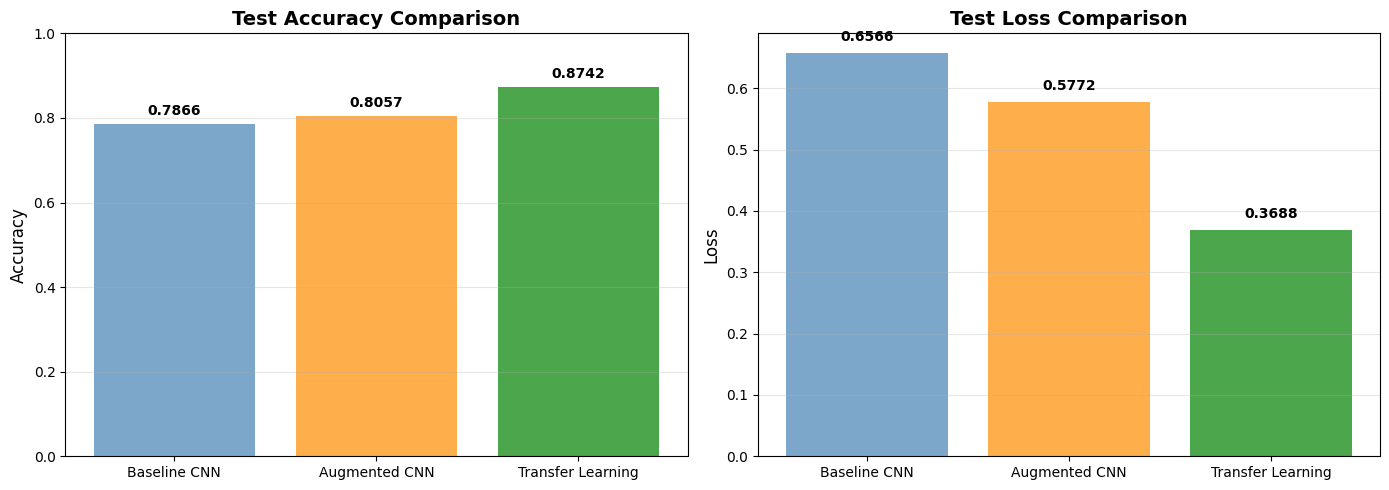


Best Model: Transfer Learning with 87.42% accuracy


In [24]:
# Model Comparison - Baseline vs Augmented vs Transfer Learning
import json

# Load metrics from JSON files
with open('models/baseline_metrics.json', 'r') as f:
    baseline_metrics = json.load(f)

with open('models/augmented_metrics.json', 'r') as f:
    augmented_metrics = json.load(f)

# Evaluate transfer learning model
test_loss_tf, test_acc_tf = model_transfer.evaluate(x_test_resized, y_test_tf, verbose=0)

# Calculate overfitting gaps
# Note: Using best epoch values from training history
baseline_overfitting = abs(0.8232 - 0.7787)  # Approx from epoch 10 
augmented_overfitting = abs(history_aug.history['accuracy'][-1] - history_aug.history['val_accuracy'][-1])
transfer_overfitting = abs(history_transfer.history['accuracy'][-1] - history_transfer.history['val_accuracy'][-1])

comparison_data = {
    'Model': ['Baseline CNN', 'Augmented CNN', 'Transfer Learning'],
    'Test Accuracy': [
        baseline_metrics['test_accuracy'],
        augmented_metrics['test_accuracy'],
        test_acc_tf
    ],
    'Test Loss': [
        baseline_metrics['test_loss'],
        augmented_metrics['test_loss'],
        test_loss_tf
    ],
    'Overfitting Gap': [
        f'{baseline_overfitting:.2%}',
        f'{augmented_overfitting:.2%}',
        f'{transfer_overfitting:.2%}'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("=" * 70)
print("MODEL COMPARISON")
print("=" * 70)
print(comparison_df.to_string(index=False))
print("=" * 70)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
colors = ['steelblue', 'darkorange', 'green']
models = comparison_data['Model']
accuracies = comparison_data['Test Accuracy']

axes[0].bar(models, accuracies, color=colors, alpha=0.7)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1)
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold', fontsize=10)

# Loss comparison
losses = comparison_data['Test Loss']
axes[1].bar(models, losses, color=colors, alpha=0.7)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Test Loss Comparison', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(losses):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('figures/three_model_comparison.png', dpi=300)
plt.show()

# Print winner
best_model_idx = accuracies.index(max(accuracies))
print(f"\nBest Model: {models[best_model_idx]} with {accuracies[best_model_idx]:.2%} accuracy")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
TRANSFER LEARNING - CLASSIFICATION REPORT
              precision    recall  f1-score   support

    airplane       0.90      0.87      0.89      1000
  automobile       0.91      0.95      0.93      1000
        bird       0.89      0.83      0.86      1000
         cat       0.73      0.81      0.77      1000
        deer       0.81      0.88      0.84      1000
         dog       0.87      0.77      0.82      1000
        frog       0.90      0.90      0.90      1000
       horse       0.89      0.89      0.89      1000
        ship       0.92      0.93      0.92      1000
       truck       0.94      0.91      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



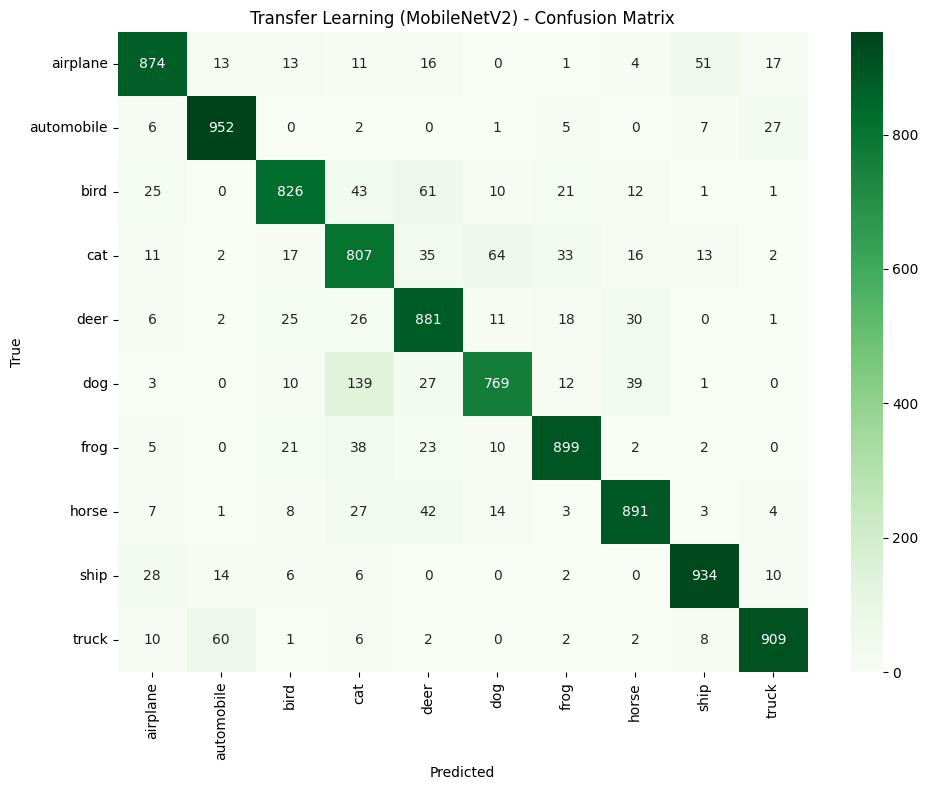


Transfer learning metrics saved to models/transfer_metrics.json


In [25]:
# Transfer Learning - Complete Evaluation
from sklearn.metrics import classification_report, confusion_matrix

# Predictions
predictions_tf = model_transfer.predict(x_test_resized)
predicted_classes_tf = np.argmax(predictions_tf, axis=1)
true_classes_tf = np.argmax(y_test_tf, axis=1)

# Classification Report
print("=" * 70)
print("TRANSFER LEARNING - CLASSIFICATION REPORT")
print("=" * 70)
print(classification_report(true_classes_tf, predicted_classes_tf, target_names=list(classes.values())))

# Confusion Matrix
cm_tf = confusion_matrix(true_classes_tf, predicted_classes_tf)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_tf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=list(classes.values()), 
            yticklabels=list(classes.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Transfer Learning (MobileNetV2) - Confusion Matrix')
plt.tight_layout()
plt.savefig('figures/confusion_matrix_transfer.png', dpi=300)
plt.show()

# Save transfer learning metrics
transfer_metrics = {
    'test_accuracy': float(test_acc_tf),
    'test_loss': float(test_loss_tf),
    'classification_report': classification_report(true_classes_tf, predicted_classes_tf, 
                                                   target_names=list(classes.values()), 
                                                   output_dict=True)
}

with open('models/transfer_metrics.json', 'w') as f:
    json.dump(transfer_metrics, f, indent=2)

print("\nTransfer learning metrics saved to models/transfer_metrics.json")